<a href="https://colab.research.google.com/github/SreeBhagya-S/TKM_21/blob/main/Conference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install transformers

     |████████████████████████████████| 3.8 MB 4.3 MB/s 
     |████████████████████████████████| 6.5 MB 37.0 MB/s 
     |████████████████████████████████| 895 kB 46.0 MB/s 
     |████████████████████████████████| 596 kB 50.3 MB/s 
     |████████████████████████████████| 67 kB 5.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score

import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from keras.models import Model
from tensorflow.keras import utils as np_utils
from keras.utils.np_utils import to_categorical

import transformers
from transformers import AutoTokenizer,DistilBertModel, DistilBertConfig
from transformers import TFAutoModel

import warnings
warnings.filterwarnings("ignore")

In [3]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [5]:
df = pd.read_csv('/content/drive/MyDrive/TKM/references for review analysis/datasets/Dravidian_codemix/malayalam_train.tsv',  sep='\t', header=0)
df_test = pd.read_csv('/content/drive/MyDrive/TKM/references for review analysis/datasets/Dravidian_codemix/malayalam_test_results - malayalam_test_results.tsv',  sep='\t', header=0)

In [6]:
labels = ['Mixed_feelings','Negative','Positive','not-malayalam ','unknown_state']


In [7]:
X_train = df.text
X_test = df_test.text

y_train = df.category
y_test = df_test.category

In [14]:
y_train.shape

(4851,)

In [13]:
y_train.value_counts()

Positive           2022
unknown_state      1344
not-malayalam       647
Negative            549
Mixed_feelings      289
Name: category, dtype: int64

In [15]:
y_test.shape

(1348,)

In [12]:
y_test.value_counts()

Positive          565
unknown_state     398
not-malayalam     177
Negative          138
Mixed_feelings     70
Name: category, dtype: int64

In [7]:
encoder = LabelEncoder()
encoder.fit(y_train)

y_train = encoder.transform(y_train)
encoder.fit(y_test)
y_test = encoder.transform(y_test)

num_classes = np.max(y_train) + 1
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [8]:
# Tokenization of the data
def text_encode(text, tokenizer, max_len=100):
    tokens = text.apply(lambda x: tokenizer(x,return_tensors='tf', 
                                            truncation=True,
                                            padding='max_length',
                                            max_length=max_len, 
                                            add_special_tokens=True))
    input_ids= []
    attention_mask=[]
    for item in tokens:
        input_ids.append(item['input_ids'])
        attention_mask.append(item['attention_mask'])
    input_ids, attention_mask=np.squeeze(input_ids), np.squeeze(attention_mask)

    return [input_ids,attention_mask]

In [9]:
# model creation
def build_model(b_model, maxlen=100):
   input_ids = tf.keras.Input(shape=(maxlen,),dtype=tf.int32, name='input_ids')
   attention_mask = tf.keras.Input(shape=(maxlen,),dtype=tf.int32, name='attention_mask')

   sequence_output = b_model(input_ids,attention_mask=attention_mask)
   output = sequence_output[0][:,0,:]
   output = tf.keras.layers.Dense(32,activation='relu')(output)
   output = tf.keras.layers.Dropout(0.2)(output)
   output = tf.keras.layers.Dense(5,activation='softmax')(output)

   model = tf.keras.models.Model(inputs = [input_ids,attention_mask], outputs = [output])
   model.compile(Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

   return model

In [10]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

**XLM**

In [11]:
from transformers import XLMForSequenceClassification, XLMTokenizer, XLMConfig

In [12]:
# Creating tokenizer
tokenizer_xlm = AutoTokenizer.from_pretrained('xlm-clm-enfr-1024')
pt_xlm = TFAutoModel.from_pretrained('xlm-clm-enfr-1024')

Downloading:   0%|          | 0.00/131 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/985k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/792M [00:00<?, ?B/s]

Some layers from the model checkpoint at xlm-clm-enfr-1024 were not used when initializing TFXLMModel: ['pred_layer_._proj']
- This IS expected if you are initializing TFXLMModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLMModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFXLMModel were initialized from the model checkpoint at xlm-clm-enfr-1024.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMModel for predictions without further training.


In [13]:
X_train_input_ids, X_train_attention_mask = text_encode(X_train, tokenizer_xlm, max_len=100)
X_test_input_ids, X_test_attention_mask = text_encode(X_test, tokenizer_xlm, max_len=100)

In [14]:
model = build_model(pt_xlm, maxlen=100)

In [15]:
history = model.fit(
    [X_train_input_ids, X_train_attention_mask],
    y_train,
    batch_size=32,
    validation_data=([X_test_input_ids, X_test_attention_mask], y_test),
    epochs=10
)

Epoch 1/10
152/152 [==============================] - 91s 541ms/step - loss: 1.6062 - accuracy: 0.3086 - val_loss: 1.3383 - val_accuracy: 0.4488
Epoch 2/10
152/152 [==============================] - 83s 543ms/step - loss: 1.3993 - accuracy: 0.4053 - val_loss: 1.2645 - val_accuracy: 0.4577
Epoch 3/10
152/152 [==============================] - 83s 543ms/step - loss: 1.2978 - accuracy: 0.4780 - val_loss: 1.1334 - val_accuracy: 0.5734
Epoch 4/10
152/152 [==============================] - 83s 544ms/step - loss: 1.2242 - accuracy: 0.5172 - val_loss: 1.1223 - val_accuracy: 0.5809
Epoch 5/10
152/152 [==============================] - 82s 543ms/step - loss: 1.1374 - accuracy: 0.5389 - val_loss: 0.9866 - val_accuracy: 0.6254
Epoch 6/10
152/152 [==============================] - 83s 543ms/step - loss: 1.0840 - accuracy: 0.5685 - val_loss: 1.0699 - val_accuracy: 0.5875
Epoch 7/10
152/152 [==============================] - 83s 543ms/step - loss: 1.0064 - accuracy: 0.5984 - val_loss: 0.9633 - val_ac

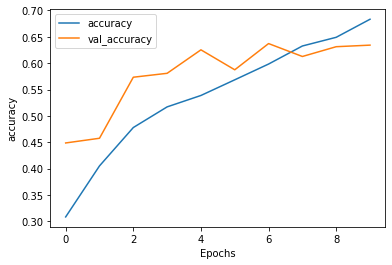

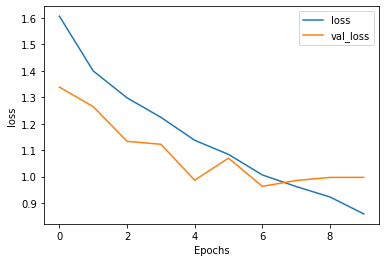

In [16]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [17]:
y_predicted = model.predict([X_test_input_ids, X_test_attention_mask])

In [18]:
print(classification_report(np.argmax(y_test,axis=1),np.argmax(y_predicted,axis=1), target_names=labels))

                precision    recall  f1-score   support

Mixed_feelings       0.00      0.00      0.00        70
      Negative       0.36      0.67      0.47       138
      Positive       0.67      0.84      0.74       565
not-malayalam        0.77      0.61      0.68       177
 unknown_state       0.74      0.46      0.57       398

      accuracy                           0.63      1348
     macro avg       0.51      0.51      0.49      1348
  weighted avg       0.64      0.63      0.62      1348



**XLNET**

In [19]:
from transformers import XLNetTokenizer, XLNetModel

In [20]:
# Creating tokenizer
tokenizer_xlnet = AutoTokenizer.from_pretrained('xlnet-base-cased')
pt_xlnet = TFAutoModel.from_pretrained('xlnet-base-cased')

Downloading:   0%|          | 0.00/760 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/779k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/539M [00:00<?, ?B/s]

Some layers from the model checkpoint at xlnet-base-cased were not used when initializing TFXLNetModel: ['lm_loss']
- This IS expected if you are initializing TFXLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFXLNetModel were initialized from the model checkpoint at xlnet-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLNetModel for predictions without further training.


In [21]:
X_train_input_ids, X_train_attention_mask = text_encode(X_train, tokenizer_xlnet, max_len=100)
X_test_input_ids, X_test_attention_mask = text_encode(X_test, tokenizer_xlnet, max_len=100)

In [22]:
model = build_model(pt_xlnet, maxlen=100)

In [23]:
history = model.fit(
    [X_train_input_ids, X_train_attention_mask],
    y_train,
    batch_size=32,
    validation_data=([X_test_input_ids, X_test_attention_mask], y_test),
    epochs=10
)

Epoch 1/10
152/152 [==============================] - 149s 894ms/step - loss: 1.5929 - accuracy: 0.3869 - val_loss: 1.3543 - val_accuracy: 0.4332
Epoch 2/10
152/152 [==============================] - 133s 876ms/step - loss: 1.4018 - accuracy: 0.4236 - val_loss: 1.2345 - val_accuracy: 0.5037
Epoch 3/10
152/152 [==============================] - 134s 879ms/step - loss: 1.3132 - accuracy: 0.4809 - val_loss: 1.1348 - val_accuracy: 0.5579
Epoch 4/10
152/152 [==============================] - 133s 878ms/step - loss: 1.1780 - accuracy: 0.5446 - val_loss: 1.0647 - val_accuracy: 0.5979
Epoch 5/10
152/152 [==============================] - 133s 878ms/step - loss: 1.0667 - accuracy: 0.5949 - val_loss: 1.0454 - val_accuracy: 0.6016
Epoch 6/10
152/152 [==============================] - 133s 878ms/step - loss: 0.9941 - accuracy: 0.6211 - val_loss: 1.0619 - val_accuracy: 0.6313
Epoch 7/10
152/152 [==============================] - 133s 877ms/step - loss: 0.9554 - accuracy: 0.6399 - val_loss: 1.0481 -

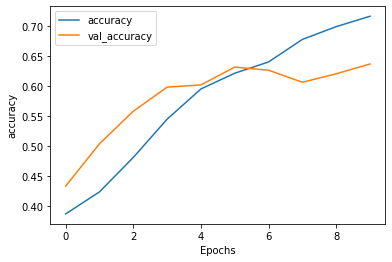

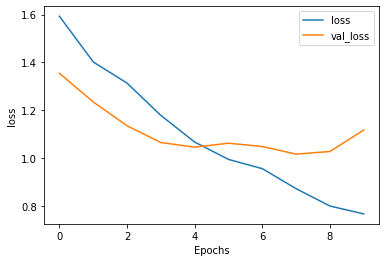

In [24]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [25]:
y_predicted = model.predict([X_test_input_ids, X_test_attention_mask])

In [26]:
print(classification_report(np.argmax(y_test,axis=1),np.argmax(y_predicted,axis=1), target_names=labels))

                precision    recall  f1-score   support

Mixed_feelings       0.57      0.17      0.26        70
      Negative       0.36      0.72      0.48       138
      Positive       0.70      0.78      0.74       565
not-malayalam        0.72      0.65      0.68       177
 unknown_state       0.74      0.47      0.58       398

      accuracy                           0.64      1348
     macro avg       0.62      0.56      0.55      1348
  weighted avg       0.67      0.64      0.63      1348



**Bert**

In [27]:
from transformers.models import bert

In [28]:
# Creating tokenizer
tokenizer_bert = AutoTokenizer.from_pretrained('bert-base-uncased')
pt_bert = TFAutoModel.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [29]:
for layer in pt_bert.layers:
      layer.trainable = True

In [30]:
X_train_input_ids, X_train_attention_mask = text_encode(X_train, tokenizer_bert, max_len=100)
X_test_input_ids, X_test_attention_mask = text_encode(X_test, tokenizer_bert, max_len=100)

In [31]:
model = build_model(pt_bert, maxlen=100)

In [32]:
history = model.fit(
    [X_train_input_ids, X_train_attention_mask],
    y_train,
    batch_size=32,
    validation_data=([X_test_input_ids, X_test_attention_mask], y_test),
    epochs=10
)

Epoch 1/10
152/152 [==============================] - 121s 701ms/step - loss: 1.2313 - accuracy: 0.5055 - val_loss: 0.9987 - val_accuracy: 0.6165
Epoch 2/10
152/152 [==============================] - 104s 682ms/step - loss: 0.9917 - accuracy: 0.6390 - val_loss: 0.9291 - val_accuracy: 0.6513
Epoch 3/10
152/152 [==============================] - 103s 681ms/step - loss: 0.8615 - accuracy: 0.6753 - val_loss: 0.8619 - val_accuracy: 0.6743
Epoch 4/10
152/152 [==============================] - 103s 680ms/step - loss: 0.7386 - accuracy: 0.7308 - val_loss: 0.8682 - val_accuracy: 0.6766
Epoch 5/10
152/152 [==============================] - 103s 680ms/step - loss: 0.6305 - accuracy: 0.7716 - val_loss: 0.8511 - val_accuracy: 0.7070
Epoch 6/10
152/152 [==============================] - 103s 680ms/step - loss: 0.5184 - accuracy: 0.8130 - val_loss: 0.9758 - val_accuracy: 0.6958
Epoch 7/10
152/152 [==============================] - 103s 680ms/step - loss: 0.4469 - accuracy: 0.8392 - val_loss: 0.9557 -

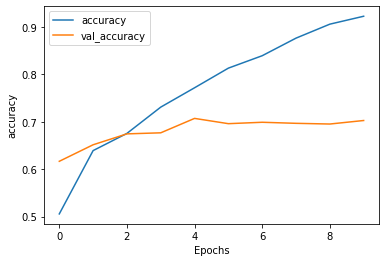

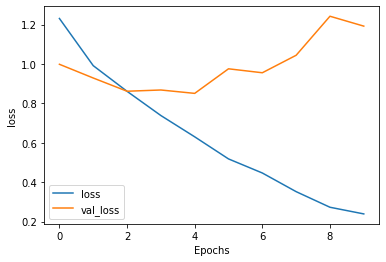

In [33]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [34]:
y_predicted = model.predict([X_test_input_ids, X_test_attention_mask])

In [35]:
print(classification_report(np.argmax(y_test,axis=1),np.argmax(y_predicted,axis=1), target_names=labels))

                precision    recall  f1-score   support

Mixed_feelings       0.36      0.36      0.36        70
      Negative       0.56      0.49      0.52       138
      Positive       0.74      0.83      0.78       565
not-malayalam        0.77      0.76      0.77       177
 unknown_state       0.71      0.64      0.67       398

      accuracy                           0.70      1348
     macro avg       0.63      0.61      0.62      1348
  weighted avg       0.70      0.70      0.70      1348



**Distil Bert**

In [36]:
from transformers.models import distilbert

In [37]:
# Creating tokenizer
tokenizer_dbert = AutoTokenizer.from_pretrained('distilbert-base-uncased')

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [38]:
pt_dbert = TFAutoModel.from_pretrained('distilbert-base-uncased')

Downloading:   0%|          | 0.00/347M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_transform', 'vocab_projector', 'vocab_layer_norm', 'activation_13']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [39]:
for layer in pt_dbert.layers:
      layer.trainable = True

In [40]:
X_train_input_ids, X_train_attention_mask = text_encode(X_train, tokenizer_dbert, max_len=100)
X_test_input_ids, X_test_attention_mask = text_encode(X_test, tokenizer_dbert, max_len=100)

In [41]:
model = build_model(pt_dbert, maxlen=100)

In [42]:
history = model.fit(
    [X_train_input_ids, X_train_attention_mask],
    y_train,
    batch_size=32,
    validation_data=([X_test_input_ids, X_test_attention_mask], y_test),
    epochs=10
)

Epoch 1/10
152/152 [==============================] - 62s 359ms/step - loss: 1.2751 - accuracy: 0.4923 - val_loss: 1.0501 - val_accuracy: 0.5809
Epoch 2/10
152/152 [==============================] - 52s 345ms/step - loss: 1.0257 - accuracy: 0.6013 - val_loss: 0.9430 - val_accuracy: 0.6358
Epoch 3/10
152/152 [==============================] - 52s 345ms/step - loss: 0.8825 - accuracy: 0.6737 - val_loss: 0.9067 - val_accuracy: 0.6439
Epoch 4/10
152/152 [==============================] - 53s 346ms/step - loss: 0.7885 - accuracy: 0.7141 - val_loss: 0.8537 - val_accuracy: 0.6580
Epoch 5/10
152/152 [==============================] - 52s 345ms/step - loss: 0.6786 - accuracy: 0.7493 - val_loss: 0.8645 - val_accuracy: 0.6914
Epoch 6/10
152/152 [==============================] - 52s 345ms/step - loss: 0.5873 - accuracy: 0.7856 - val_loss: 0.8969 - val_accuracy: 0.6766
Epoch 7/10
152/152 [==============================] - 52s 345ms/step - loss: 0.4969 - accuracy: 0.8147 - val_loss: 0.9009 - val_ac

In [43]:
loss, accuracy = model.evaluate([X_test_input_ids, X_test_attention_mask], y_test)
print('Test accuracy :', accuracy*100,"%")

43/43 [==============================] - 5s 109ms/step - loss: 1.2219 - accuracy: 0.6884
Test accuracy : 68.84273290634155 %


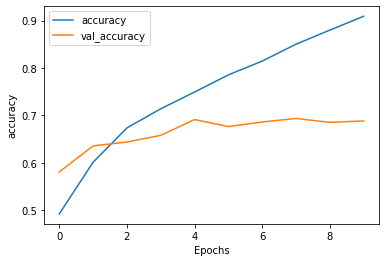

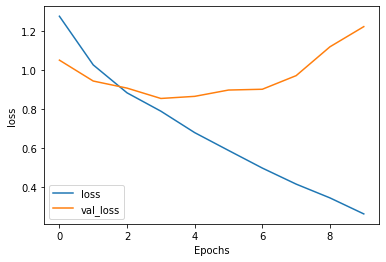

In [44]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [45]:
y_predicted = model.predict([X_test_input_ids, X_test_attention_mask])
print(classification_report(np.argmax(y_test,axis=1),np.argmax(y_predicted,axis=1), target_names=labels))

                precision    recall  f1-score   support

Mixed_feelings       0.29      0.41      0.34        70
      Negative       0.53      0.46      0.49       138
      Positive       0.75      0.80      0.77       565
not-malayalam        0.70      0.80      0.75       177
 unknown_state       0.75      0.61      0.67       398

      accuracy                           0.69      1348
     macro avg       0.60      0.62      0.60      1348
  weighted avg       0.70      0.69      0.69      1348



**RoBERTa**

In [46]:
from transformers.models import roberta

In [47]:
# Creating tokenizer
tokenizer_rbert = AutoTokenizer.from_pretrained('roberta-base')
pt_rbert = TFAutoModel.from_pretrained('roberta-base')

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/627M [00:00<?, ?B/s]

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [48]:
for layer in pt_rbert.layers:
      layer.trainable = True

In [49]:
X_train_input_ids, X_train_attention_mask = text_encode(X_train, tokenizer_rbert, max_len=100)
X_test_input_ids, X_test_attention_mask = text_encode(X_test, tokenizer_rbert, max_len=100)

In [50]:
model = build_model(pt_rbert, maxlen=100)

In [51]:
history = model.fit(
    [X_train_input_ids, X_train_attention_mask],
    y_train,
    batch_size=32,
    validation_data=([X_test_input_ids, X_test_attention_mask], y_test),
    epochs=10
)

Epoch 1/10
152/152 [==============================] - 121s 702ms/step - loss: 1.2928 - accuracy: 0.4620 - val_loss: 1.0649 - val_accuracy: 0.5898
Epoch 2/10
152/152 [==============================] - 104s 686ms/step - loss: 1.0624 - accuracy: 0.6005 - val_loss: 0.9616 - val_accuracy: 0.6417
Epoch 3/10
152/152 [==============================] - 104s 687ms/step - loss: 0.9524 - accuracy: 0.6458 - val_loss: 0.9010 - val_accuracy: 0.6639
Epoch 4/10
152/152 [==============================] - 104s 687ms/step - loss: 0.8390 - accuracy: 0.6910 - val_loss: 0.8739 - val_accuracy: 0.6736
Epoch 5/10
152/152 [==============================] - 104s 686ms/step - loss: 0.7778 - accuracy: 0.7153 - val_loss: 0.9165 - val_accuracy: 0.6625
Epoch 6/10
152/152 [==============================] - 104s 686ms/step - loss: 0.6933 - accuracy: 0.7407 - val_loss: 0.8532 - val_accuracy: 0.6884
Epoch 7/10
152/152 [==============================] - 104s 687ms/step - loss: 0.6239 - accuracy: 0.7644 - val_loss: 0.9154 -

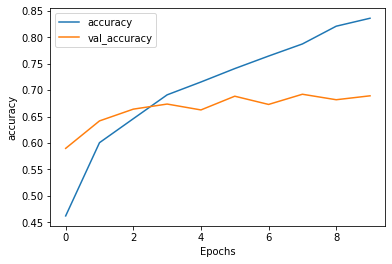

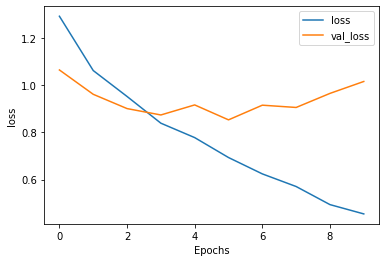

In [52]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [53]:
y_predicted = model.predict([X_test_input_ids, X_test_attention_mask])

In [54]:
print(classification_report(np.argmax(y_test,axis=1),np.argmax(y_predicted,axis=1), target_names=labels))

                precision    recall  f1-score   support

Mixed_feelings       0.31      0.31      0.31        70
      Negative       0.43      0.54      0.48       138
      Positive       0.76      0.81      0.78       565
not-malayalam        0.76      0.83      0.79       177
 unknown_state       0.75      0.57      0.65       398

      accuracy                           0.69      1348
     macro avg       0.60      0.61      0.60      1348
  weighted avg       0.70      0.69      0.69      1348

